# Train Scikit-Learn Contract Type Classifier


*Version: 2022-04-19*

---

**Imports**

In [1]:
# standard library
from pathlib import Path
from collections import Counter
from typing import Dict, Final, Generator, List, Tuple

# third-party libraries
import cloudpickle
import matplotlib.pyplot
from numpy import ndarray
from psutil import Process
from gensim.models import Doc2Vec
from pandas import DataFrame, read_csv, concat

# LexNLP
from lexnlp.nlp.en.tokens import get_lemmas
from lexnlp.ml.normalizers import Normalizer
from lexnlp.ml.sklearn_transformers import (
    parallel_estimator,
    TransformerVectorizer,
    TransformerPreprocessor,
)
from lexnlp.ml.vectorizers import VectorizerDoc2Vec, VectorizerKeywordSearch
from lexnlp.extract.en.contracts.predictors import ProbabilityPredictorContractType
from lexnlp.extract.en.addresses.addresses import get_address_annotations
from lexnlp.extract.en.amounts import get_amount_annotations
from lexnlp.extract.en.dates import get_date_annotations
from lexnlp.extract.en.percents import get_percent_annotations
from lexnlp.extract.en.ratios import get_ratio_annotations

# Scikit-Learn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

/home/aparsons/lexpredict-contraxsuite-core/venv_lexpredict_contraxsuite_core/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aparsons/lexpredict-contraxsuite-core/venv_lexpredict_contraxsuite_core/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


---

## Constants

In [2]:
# directory paths
PATH_PREPROCESSED: Final[Path] = Path('./preprocessed/')

# Doc2Vec model
PATH_DOC2VEC_MODEL: Final[Path] = Path('./output/vectorsize200_window10_dmTrue_mincount20_epochs40.doc2vec')
doc2vec_model: Doc2Vec = Doc2Vec.load(str(PATH_DOC2VEC_MODEL))

# number of processors to use for multiprocessing
MAX_WORKERS: Final[int] = (len(Process().cpu_affinity()) - 0) or 1

---

## Preparing Training Data

First, create lists for training data and respective targets/labels.

The two datasets are:

- `corpus/contract-types`
- `corpus/atticus-cuad-v1-plaintext`

These datasets have overlapping but not identical sets of labels. Below is a label mapping.

In [3]:
LABEL_MAPPING: Final[Dict[str, str]] ={
    'CONSULTING AGREEMENT': 'ADVISORY AGREEMENT',
    'DISTRIBUTOR AGREEMENT': 'DISTRIBUTION AGREEMENT',
    'SERVICE AGREEMENT': 'SERVICES AGREEMENT',
    'OPERATING AGREEMENT': 'MANAGEMENT AGREEMENT',
}

In [5]:
# assemble a singular Pandas DataFrame from all preprocessed CSV files
csv_files: Tuple[Path, ...] = tuple(PATH_PREPROCESSED.rglob('*.csv'))
dataframe: DataFrame = concat(map(read_csv, csv_files), ignore_index=True)

# rename labels based on the LABEL_MAPPING
labels: List[str] = []
for label in dataframe['label']:
    label = label.upper()
    if not label.endswith(' AGREEMENT'):
        label = f'{label} AGREEMENT'
    labels.append(LABEL_MAPPING.get(label, label))

# reassemble the Pandas DataFrame
dataframe: DataFrame = DataFrame(
    data=zip(labels, dataframe['text']),
    columns=('label', 'text')
)

# drop rows if their respective label appears fewer than seven times
# ...(seven because StratifiedKFold defaults to n_splits=5,
# ... and after train_test_split, we need five remaining samples)
for label, count in Counter(dataframe['label']).items():
    if count < 7:
        print('Dropping:', label)
        dataframe = dataframe[dataframe.label != label]

# finally, create our training data and targets
x: Tuple[str] = tuple(dataframe['text'])
y: Tuple[str] = tuple(dataframe['label'])

Dropping: NON_COMPETE_NON_SOLICIT AGREEMENT
Dropping: FEE WAIVER AGREEMENT
Dropping: PLEDGE AGREEMENT
Dropping: PROMISSORY NOTE AGREEMENT
Dropping: REPURCHASE AGREEMENTS AGREEMENT
Dropping: FUND ACCOUNTING AGREEMENT


Split into training and test sets using Scikit-Learn's cannonical `train_test_split(...)`

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
)

---

## Preparing a `TransformerVectorizer`

We will use the `TransformerVectorizer` to create vector representations of strings.

The `TransformerVectorizer` inherits from Scikit-Learn's `BaseEstimator` and `TransformerMixin` classes.
It takes any number of implementations of `Vectorizer`, successively concatenating their `vectorize(tokens)` outputs.

In [7]:
def generate_keywords_from_labels(labels) -> Generator[Tuple[str, float, float], None, None]:
    for label in labels:
        for lemma in get_lemmas(
            text=label.lower().split('agreement')[0],
            lowercase=False,  # we already lower-cased the input
            stopword=True,
        ):
            if lemma.isalpha():
                yield lemma, 1.0, -1.0



In [8]:
transformer_vectorizer: TransformerVectorizer = TransformerVectorizer(
    vectorizers=(
        VectorizerDoc2Vec(doc2vec=doc2vec_model),
        VectorizerKeywordSearch(
            keywords=(*generate_keywords_from_labels(set(y)),),
        ),
    ),
)

---

## Data Visualization

To visually understand the data, we can:

1. Vectorize the data
2. Reduce the dimensionality of our data from *N*-dimensions down to just two
3. Plot the vectors using `matplotlib`

In [9]:
tsne: TSNE = TSNE(
    n_components=2,
    perplexity=40.0,
    metric='cosine',
    n_jobs=MAX_WORKERS,
)

pipeline_visualization: Pipeline = make_pipeline(
    transformer_vectorizer,
    MinMaxScaler(feature_range=(-1.0, 1.0))
)

In [10]:
colors: Final[Dict[str, int]] = {
    label: i
    for i, label in enumerate(sorted(set(y)))
}
colormap = matplotlib.pyplot.cm.get_cmap(name='jet', lut=len(set(y)))

First plot `X_train`...

In [11]:
%%time
reduced_dimensionality_X_train = tsne.fit_transform(
    X=parallel_estimator(
        estimator=pipeline_visualization,
        X=X_train,
        method='fit_transform',
        n_jobs=MAX_WORKERS,
    )
)

CPU times: user 1min 27s, sys: 8.33 s, total: 1min 35s
Wall time: 3min 38s


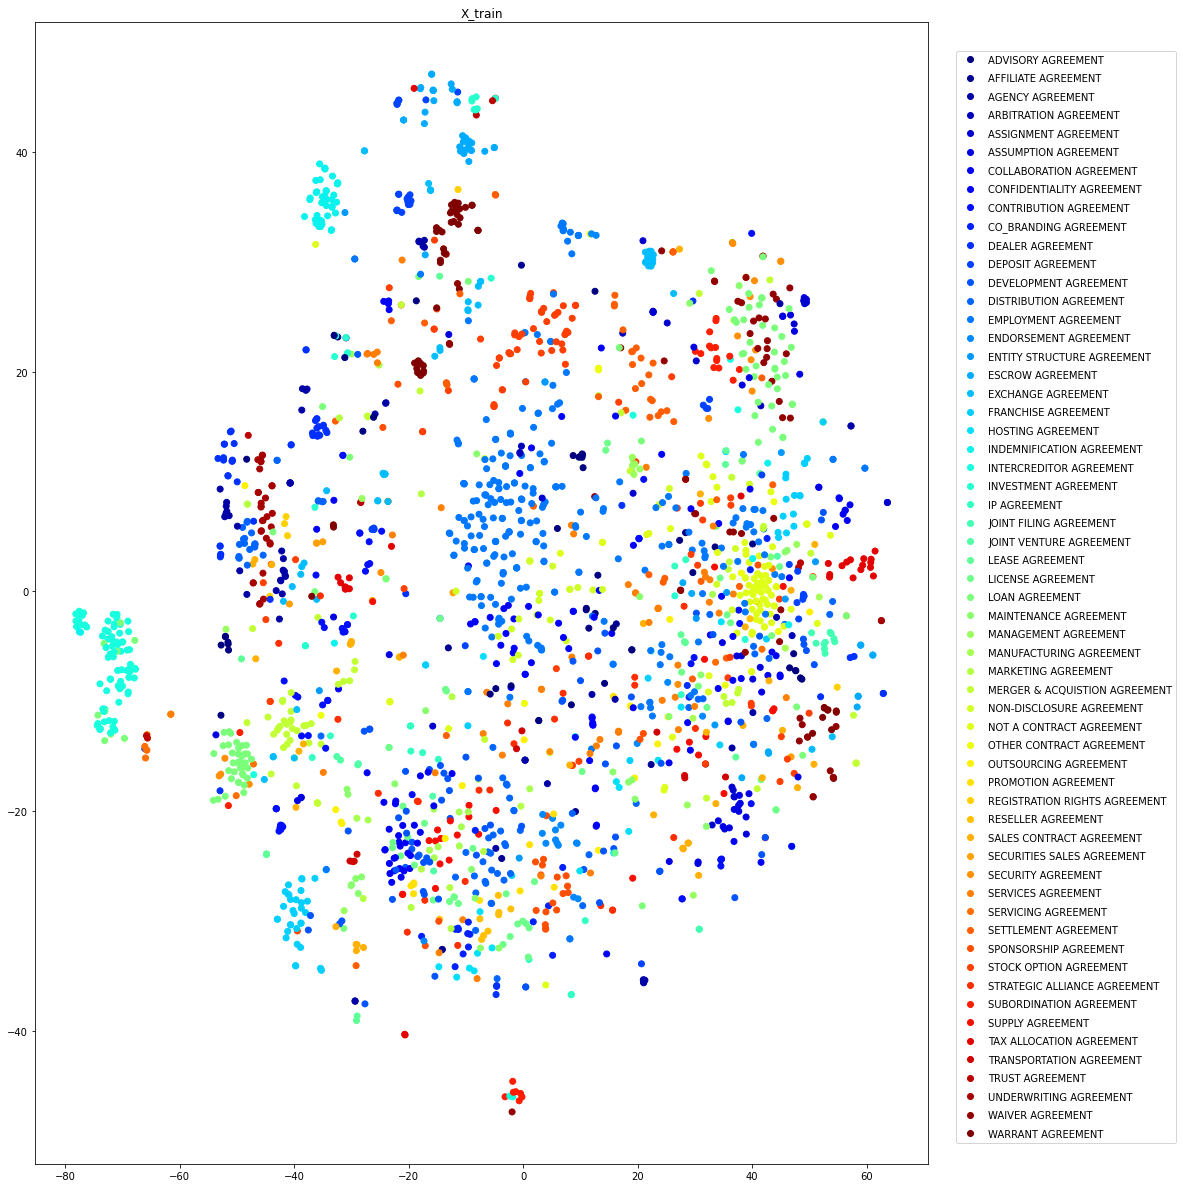

In [12]:
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(16, 21))
matplotlib.pyplot.title('X_train')
scatter = axis.scatter(
    x=reduced_dimensionality_X_train[:,0],
    y=reduced_dimensionality_X_train[:,1],
    c=[colors[label] for label in y_train],
    cmap=colormap,
)
figure.legend(
    handles=scatter.legend_elements(num=len(colors))[0],
    labels=colors.keys(),
    loc='center left',
    bbox_to_anchor=(0.92, 0.5),
    labelspacing=0.85,
)
matplotlib.pyplot.show()

...and now, the same with `X_test`.

In [13]:
%%time
reduced_dimensionality_X_test = tsne.fit_transform(
    X=parallel_estimator(
        estimator=pipeline_visualization,
        X=X_test,
        method='fit_transform',
        n_jobs=MAX_WORKERS,
    )
)

CPU times: user 1min 17s, sys: 1.6 s, total: 1min 19s
Wall time: 58 s


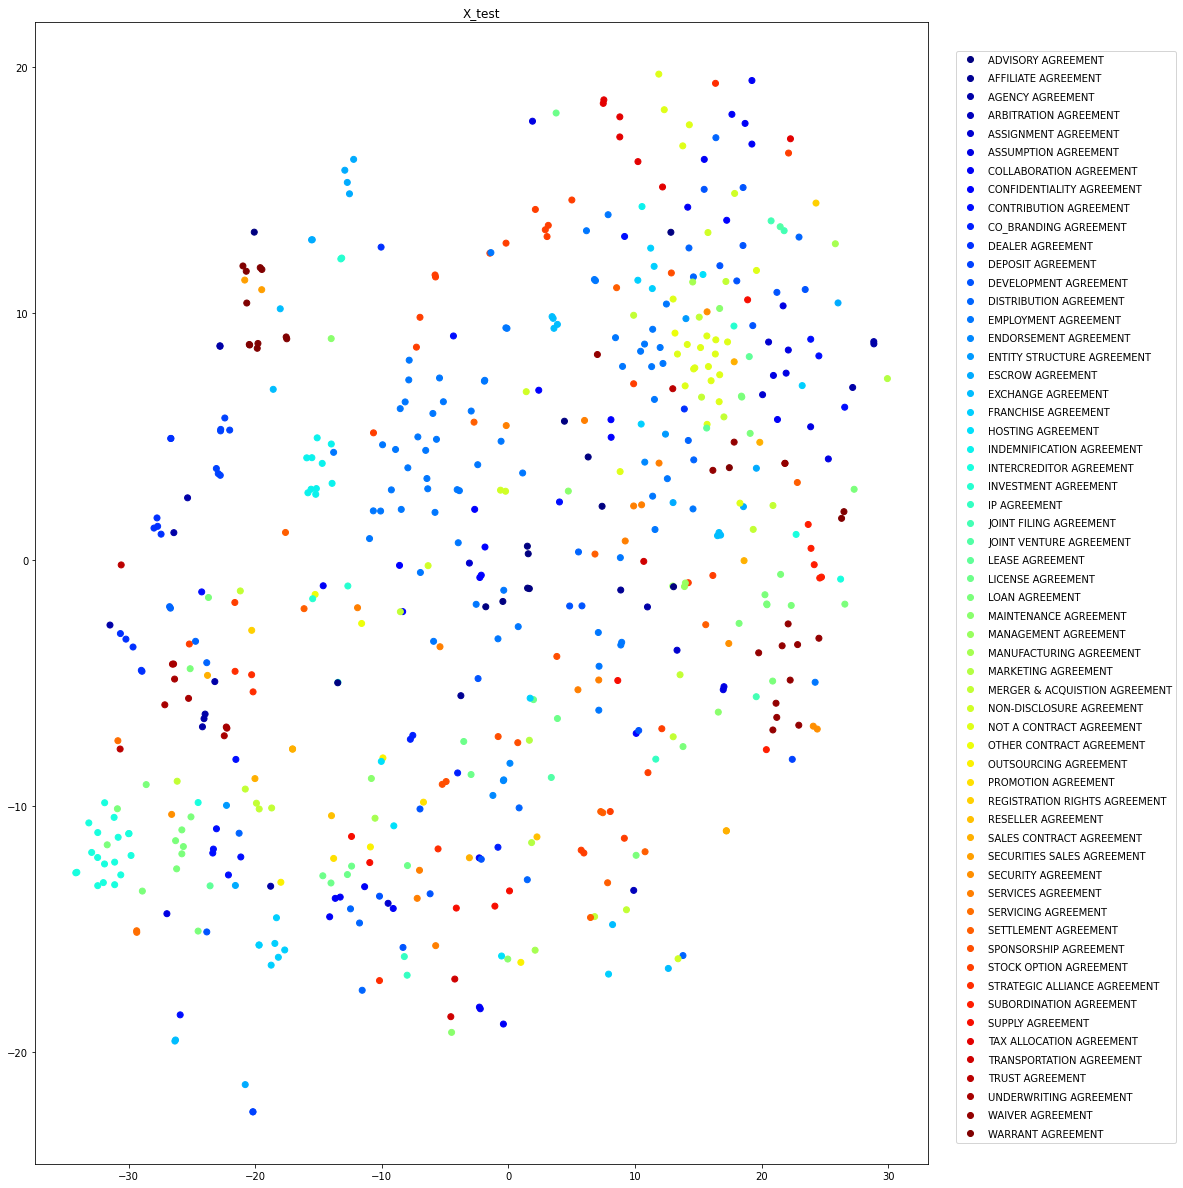

In [14]:
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(16, 21))
matplotlib.pyplot.title('X_test')
scatter = axis.scatter(
    x=reduced_dimensionality_X_test[:,0],
    y=reduced_dimensionality_X_test[:,1],
    c=[colors[label] for label in y_test],
    cmap=colormap,
)
figure.legend(
    handles=scatter.legend_elements(num=len(colors))[0],
    labels=colors.keys(),
    loc='center left',
    bbox_to_anchor=(0.92, 0.5),
    labelspacing=0.85,
)

matplotlib.pyplot.show()

---

## Training

Create one or more Scikit-Learn pipelines with the following steps:
1. `TransformerVectorizer`: vectorizes preprocessed text.
2. `RandomForestClassifier`, `LogisticRegressionCV`, `GaussianNB`, or other: classifies text as positive or negative examples of contracts.

In [ ]:
pipeline_random_forest: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    RandomForestClassifier(
        n_estimators=100,
        random_state=0,
        class_weight='balanced',
        n_jobs=MAX_WORKERS,
    )
)

In [15]:
pipeline_logistic_regression: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    LogisticRegressionCV(
        n_jobs=MAX_WORKERS,
        class_weight='balanced',
        max_iter=1000,
    ),
)

In [ ]:
pipeline_k_nearest_neighbors: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    KNeighborsClassifier(
        n_neighbors=3,
        n_jobs=MAX_WORKERS,
    ),
)

Finally, fit the pipeline(s) to the training data.

In [ ]:
%%time
pipeline_random_forest: Pipeline = pipeline_random_forest.fit(X_train, y_train)

In [16]:
%%time
pipeline_logistic_regression: Pipeline = pipeline_logistic_regression.fit(X_train, y_train)

CPU times: user 8min 33s, sys: 52.4 s, total: 9min 26s
Wall time: 9min 32s


In [ ]:
%%time
pipeline_k_nearest_neighbors: Pipeline = pipeline_k_nearest_neighbors.fit(X_train, y_train)

---

## Metrics

For each trained pipeline, evaluate test performance.

In [ ]:
%%time

# noinspection PyProtectedMember
final_estimator = pipeline_random_forest._final_estimator

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_random_forest,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)

confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    ),
    display_labels=final_estimator.classes_,
)

figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(12, 12))
matplotlib.pyplot.title(f'Confusion Matrix: {final_estimator.__class__.__name__.upper()}')
confusion_matrix_display.plot(cmap='Greys', ax=axis, xticks_rotation='vertical')

print(final_estimator.__class__.__name__.upper())
print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

/home/aparsons/lexpredict-contraxsuite-core/venv_lexpredict_contraxsuite_core/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aparsons/lexpredict-contraxsuite-core/venv_lexpredict_contraxsuite_core/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentati

LOGISTICREGRESSIONCV
                               precision    recall  f1-score   support

           ADVISORY AGREEMENT       0.64      0.69      0.67        13
          AFFILIATE AGREEMENT       0.67      1.00      0.80         2
             AGENCY AGREEMENT       0.82      0.64      0.72        14
        ARBITRATION AGREEMENT       1.00      1.00      1.00         1
         ASSIGNMENT AGREEMENT       0.25      0.40      0.31         5
         ASSUMPTION AGREEMENT       0.33      0.30      0.32        10
      COLLABORATION AGREEMENT       0.53      0.59      0.56        17
    CONFIDENTIALITY AGREEMENT       0.67      0.91      0.77        11
       CONTRIBUTION AGREEMENT       0.85      0.79      0.81        14
        CO_BRANDING AGREEMENT       0.67      0.50      0.57         4
             DEALER AGREEMENT       1.00      1.00      1.00        13
            DEPOSIT AGREEMENT       0.71      1.00      0.83        10
        DEVELOPMENT AGREEMENT       0.44      0.44     

/home/aparsons/lexpredict-contraxsuite-core/venv_lexpredict_contraxsuite_core/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


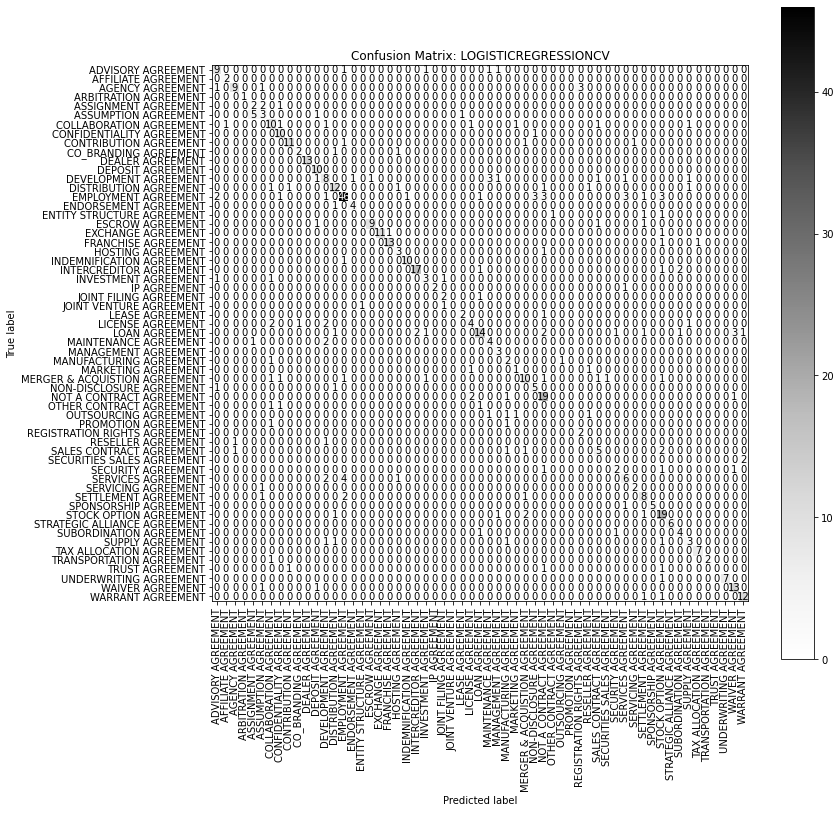

In [17]:
%%time

# noinspection PyProtectedMember
final_estimator = pipeline_logistic_regression._final_estimator

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_logistic_regression,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)

confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    ),
    display_labels=final_estimator.classes_,
)

figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(12, 12))
matplotlib.pyplot.title(f'Confusion Matrix: {final_estimator.__class__.__name__.upper()}')
confusion_matrix_display.plot(cmap='Greys', ax=axis, xticks_rotation='vertical')

print(final_estimator.__class__.__name__.upper())
print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

In [ ]:
%%time

# noinspection PyProtectedMember
final_estimator = pipeline_k_nearest_neighbors._final_estimator

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_k_nearest_neighbors,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)

confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    ),
    display_labels=final_estimator.classes_,
)

figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(12, 12))
matplotlib.pyplot.title(f'Confusion Matrix: {final_estimator.__class__.__name__.upper()}')
confusion_matrix_display.plot(cmap='Greys', ax=axis, xticks_rotation='vertical')

print(final_estimator.__class__.__name__.upper())
print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

---

## Saving the pipeline

Choose the best-performing pipeline and save it using `cloudpickle`.

First, we need the same `Normalizer` as was used to preprocess the original training data.

In [18]:
def kwarg_wrapper_get_amount_annotations(text):
    yield from get_amount_annotations(text=text, extended_sources=False)

NORMALIZER: Final[Normalizer] = Normalizer(
    normalizations=(
        (get_address_annotations, '__ADDRESS__'),
        (get_ratio_annotations, '__RATIO__'),
        (get_date_annotations, '__DATE__'),
        (get_percent_annotations, '__PERCENT__'),
        (kwarg_wrapper_get_amount_annotations, '__AMOUNT__'),
    ),
)

Then, insert at the beginning of the pipeline an instance of `TransformerPreprocessor`. Finally, save the pipeline to a file using `cloudpickle`.

In [19]:
# Insert an instance of TransformerPreprocessor
pipeline_logistic_regression.steps.insert(
    0,
    (
        TransformerPreprocessor.__name__.lower(),
        TransformerPreprocessor(normalizer=NORMALIZER, head_character_n=0)
    )
)

# now save the pipeline
with open('./output/pipeline_contract_type_classifier.cloudpickle', 'wb') as f:
    cloudpickle.dump(pipeline_logistic_regression, f)

---

## Usage

First, load the pipeline from disk.

In [20]:
with open('./output/pipeline_contract_type_classifier.cloudpickle', 'rb') as f:
    pipeline_contract_type_classifier: Pipeline = cloudpickle.load(f)

Then, pass the combined pipeline as an argument to `ProbabilityPredictorIsContract`'s `pipeline` parameter.

In [23]:
probability_predictor_contract_type: ProbabilityPredictorContractType = \
    ProbabilityPredictorContractType(pipeline=pipeline_contract_type_classifier)

probability_predictor_contract_type.detect_contract_type(
    text=['This is a sentence.', 'LICENSE AGREEMENT', 'The owner shall be responsible for the license of this software.'],
    min_probability=0.5,
)

''

In [24]:
probability_predictor_contract_type.make_predictions(
    text=['This is a sentence.', 'LICENSE AGREEMENT', 'The owner shall be responsible for the license of this software.'],
    top_n=10,
)

ADVISORY AGREEMENT           0.002259
AFFILIATE AGREEMENT          0.000318
AGENCY AGREEMENT             0.002422
ARBITRATION AGREEMENT        0.000459
ASSIGNMENT AGREEMENT         0.000565
ASSUMPTION AGREEMENT         0.001183
COLLABORATION AGREEMENT      0.002400
CONFIDENTIALITY AGREEMENT    0.002173
CONTRIBUTION AGREEMENT       0.000462
CO_BRANDING AGREEMENT        0.006509
dtype: float64

---

## Alternative: Only Saving the Classifier

This will not save the entire pipeline.

In [ ]:
with open('./output/is_contract_classifier.cloudpickle', 'wb') as f:
    # noinspection PyProtectedMember
    cloudpickle.dump(pipeline_logistic_regression._final_estimator, f)